# Script to train selected fold on exported data

this script trains the neural network, visualizes single batches for quick checking and saves results in the experiment root folder

In [4]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Tensorflow_helper import choose_gpu_by_id
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1' #seems to work with only one GPU aswell
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)
# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# ------------------------------------------ import helpers
# Notebook_imports should import glob, os, and many other standard libs
from src.utils.Notebook_imports import *
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
# local imports
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D, show_phases, show_phases_transpose
from src.utils.KerasCallbacks import get_callbacks
from src.data.Dataset import get_trainings_files
from src.data.Generators import DataGenerator
import src.models.Loss_and_metrics as metr

# import external libs
import cv2
import pandas as pd


# Set Experiment name
EXPERIMENT = 'TeaMRT_Exp_5_Sigmoid_BCE/' 
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")) # add a timestep to each project to make repeated experiments unique

# all Experiment data is saved in the Experiments_Root folder.
EXPERIMENTS_ROOT = 'exp/'
EXP_PATH = os.path.join(EXPERIMENTS_ROOT, EXPERIMENT, timestemp)


# Give Paths for saving of training supplemental material
MODEL_PATH = os.path.join(EXP_PATH, 'model', )
TENSORBOARD_PATH = os.path.join(EXP_PATH, 'tensorboard_logs')
CONFIG_PATH = os.path.join(EXP_PATH,'config')
HISTORY_PATH = os.path.join(EXP_PATH, 'history')
ensure_dir(MODEL_PATH)
ensure_dir(TENSORBOARD_PATH)
ensure_dir(CONFIG_PATH)
ensure_dir(HISTORY_PATH)

# not needed for Data Science WFT:
# define the input data paths and fold 
# first to the 4D Nrrd files, 
# second to a dataframe with a mapping of the Fold-number
# Finally the path to the metadata


DATA_PATH_SAX = '/mnt/ssd/data/acdc/wft2021/rvip/2D' # used for main training, all annotated pictures are in the HeiBox and followed 

# Load the required .csv with information on how to fold the patients. This .csv is also in the github project.
DF_FOLDS = '/mnt/ssd/data/acdc/wft2021/rvip/df_kfold.csv' #'/mnt/ssd/data/acdc/2D/df_kfold.csv'

# Not needed for Data Science WFT:
# DF_META = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase'

# To perform cross-validation multiple trainings are required. Change the fold number manually to train on a new fold. 
FOLD = 0 # a total of 4 folds across 100 patients, each with 5 cases of each of the 5 pathologies. FOLD should be between 0 and 3

# General params
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 8 # 32, 64, 24, 16, 1 for 3D use: 4
GENERATOR_WORKER = BATCHSIZE # if not set, use batchsize
EPOCHS = 500 # using 500 epochs so we run into early stopping. Processing power is not our bottleneck.

DIM = [224, 224] # network input shape for spacing of 3, (z,y,x). For 2D Images (WFT Data Science) two dimensions are enough.
SPACING = [1.2, 1.2] # if resample, resample to this spacing, (z,y,x)

# Model params
DEPTH = 4 # depth of the encoder
FILTERS = 32 # initial number of filters, will be doubled after each downsampling block
M_POOL = [2, 2]# size of max-pooling used for downsampling and upsampling
F_SIZE = [3, 3] # conv filter size
BN_FIRST = False # decide if batch normalisation between conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
PAD = 'same' # padding strategy of the conv layers
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'relu' # tf.keras.layers.LeakyReLU(), relu or any other non linear activation function
LEARNING_RATE = 1e-4 # start with a huge lr to converge fast
REDUCE_LR_ON_PLAEAU_PATIENCE = 5
DECAY_FACTOR = 0.7 # Define a learning rate decay for the ReduceLROnPlateau callback
POLY_LR_DECAY = False
MIN_LR = 1e-12 # minimal lr, smaller lr does not improve the model
DROPOUT_MIN = 0.3 # lower dropout at the shallow layers
DROPOUT_MAX = 0.5 # higher dropout at the deep layers

# Callback params
MONITOR_FUNCTION = 'loss'
MONITOR_MODE = 'min'
SAVE_MODEL_FUNCTION = 'loss'
SAVE_MODEL_MODE = 'min'
MODEL_PATIENCE = 20
SAVE_LEARNING_PROGRESS_AS_TF = True

# Generator and Augmentation params
IMG_CHANNELS = 1
MASK_VALUES = [1, 2]  #channel order: Background, upper rvip, lower rvip
MASK_CLASSES = len(MASK_VALUES) # no of labels
BORDER_MODE = cv2.BORDER_REFLECT_101 # border mode for the data generation
#IMG_INTERPOLATION = cv2.INTER_LINEAR # image interpolation in the genarator
#MSK_INTERPOLATION = cv2.INTER_NEAREST # mask interpolation in the generator
IMG_INTERPOLATION = 2
MSK_INTERPOLATION= 1
AUGMENT = True # a compose of 2D augmentation (grid distortion, 90degree rotation, brightness and shift)
AUGMENT_PROB = 0.8 # will be randomely applied to 80% of the files with a random other histogram
SHUFFLE = True
RESAMPLE = True
HIST_MATCHING = False
SCALER = 'MinMax' # MinMax, Standard or Robust

# Check if these channels are given
metrics = [
    metr.dice_coef_labels, # combination channel
    metr.dice_coef_lower, # former Myo
    metr.dice_coef_upper, # former LV
    #metr.dice_coef_rv # third channel, not needed
]

LOSS_FUNCTION = metr.bce_dice_loss # categorical cross entropy would be more fitting for further enhancements. Needs to be coupled with using the softmax function on the output-layer. 

Console_and_file_logger(EXPERIMENT, logging.INFO)
config = init_config(config=locals(), save=True)
print(config)
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))

2021-10-16 20:44:57,726 INFO -------------------- Start --------------------
2021-10-16 20:44:57,727 INFO Working directory: /mnt/ssd/git/wft21_septum_landmark_detection.
2021-10-16 20:44:57,727 INFO Log file: ./logs/TeaMRT_Exp_5_Sigmoid_BCE/.log
2021-10-16 20:44:57,727 INFO Log level for console: INFO
2021-10-16 20:44:57,728 INFO Is built with tensorflow: True
2021-10-16 20:44:57,729 INFO Visible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2021-10-16 20:44:57,747 INFO Local devices: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11200263563268081790
, name: "/

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/wft21_septum_landmark_detection
['/gpu:0', '/gpu:1']
{'__K': <module 'tensorflow.keras.backend' from '/home/sven/anaconda3/envs/septum_detection/lib/python3.6/site-packages/tensorflow/keras/backend/__init__.py'>, 'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'SEED': 42, 'EXPERIMENT': 'TeaMRT_Exp_5_Sigmoid_BCE/', 'EXPERIMENTS_ROOT': 'exp/', 'EXP_PATH': 'exp/TeaMRT_Exp_5_Sigmoid_BCE/2021-10-16_20_44', 'MODEL_PATH': 'exp/TeaMRT_Exp_5_Sigmoid_BCE/2021-10-16_20_44/model', 'TENSORBOARD_PATH': 'exp/TeaMRT_Exp_5_Sigmoid_BCE/2021-10-16_20_44/tensorboard_logs', 'CONFIG_PATH': 'exp/TeaMRT_Exp_5_Sigmoid_BCE/2021-10-16_20_44/config', 'HISTORY_PATH': 'exp/TeaMRT_Exp_5_Sigmoid_BCE/2021-10-16_20_44/history', 'DATA_PATH_SAX': '/mnt/ssd/data/acdc/wft2021/rvip/2D', 'DF_FOLDS': '/mnt/ssd/data/acdc/wft2021/rvip/df_kfold.csv', 'FOLD': 0, 'BATCHSIZE': 8, 'GENERATOR_WORKER': 8, 'EPOCHS': 500, 'DIM': [224, 224], 'SPACING': [

In [5]:
# Load SAX volumes
x_train, y_train, x_val, y_val =  get_trainings_files(data_path=DATA_PATH_SAX,path_to_folds_df=DF_FOLDS, fold=FOLD)
logging.info('SAX train CMR: {}, SAX train masks: {}'.format(len(x_train), len(y_train)))
logging.info('SAX val CMR: {}, SAX val masks: {}'.format(len(x_val), len(y_val)))

# create a batch generator
batch_generator = DataGenerator(x_train, y_train, config=config)
val_config = config.copy()
val_config['AUGMENT_GRID'] = False# make sure no augmentation will be applied to the validation data
val_config['AUGMENT'] = False
val_config['HIST_MATCHING'] = False
validation_generator = DataGenerator(x_val, y_val , config=val_config, in_memory=False)

2021-10-16 20:44:58,019 INFO Found 1902 images/masks in /mnt/ssd/data/acdc/wft2021/rvip/2D
2021-10-16 20:44:58,020 INFO Patients train: 75
2021-10-16 20:44:58,082 INFO Selected 1426 of 1902 files with 75 of 100 patients for training fold 0
2021-10-16 20:44:58,082 INFO SAX train CMR: 1426, SAX train masks: 1426
2021-10-16 20:44:58,083 INFO SAX val CMR: 476, SAX val masks: 476
2021-10-16 20:44:58,083 INFO Create DataGenerator
2021-10-16 20:44:58,089 INFO Datagenerator created with: 
 shape: [224, 224]
 spacing: [1.2, 1.2]
 batchsize: 8
 Scaler: MinMax
 Images: 1426 
 Augment: True 
 Thread workers: 8
2021-10-16 20:44:58,090 INFO Create DataGenerator
2021-10-16 20:44:58,092 INFO Datagenerator created with: 
 shape: [224, 224]
 spacing: [1.2, 1.2]
 batchsize: 8
 Scaler: MinMax
 Images: 476 
 Augment: False 
 Thread workers: 8


## Visualize one batch

In [6]:
generator = validation_generator
@interact
def select_image_in_batch(batch = (0,len(generator), 1), im = (0,BATCHSIZE- 1, 1), slice_n=(1,11), save=False, filepath='data/temp/', filename='temp_x.npy'):
    
    global x, y
    x, y = generator.__getitem__(batch)
    info('selected batch : ' + str(batch))
    # logging level == debug --> visualise the generator steps
    info('X shape: {}, Y shape: {}'.format(x.shape, y.shape))
    show_2D_or_3D(x[im], y[im], interpol='bilinear',dpi=100,f_size=(5,5))
    plt.show()
    
    plt.hist(x[im].flatten())
    plt.show()
    if save:
        ensure_dir(filepath)
        np.save(os.path.join(filepath, filename), x[im])
        logging.info('saved to {}'.format(os.path.join(filepath, filename)))

interactive(children=(IntSlider(value=29, description='batch', max=59), IntSlider(value=3, description='im', m…

# Load an existing config/model

In [5]:
# Load a previous config and by this a pre-trained model
from ipyfilechooser import FileChooser
config_chooser = FileChooser(os.path.join(os.getcwd(),'reports/configs'), 'config.json')
display(config_chooser)

FileChooser(path='/mnt/ssd/git/wft21_septum_landmark_detection/reports/configs', filename='config.json', title…

In [6]:
@interact
def interact_load_pretrained_model(config_file=glob.glob('reports/configs/{}/acdc/finetune/**/*.json'.format(config.get('ARCHITECTURE', '2D')), recursive=False), load=False):
    """
    load past config for model training 
    """
    # load config with all params into global namespace
    from src.models.ModelUtils import load_pretrained_model
    if load:
        with open(config_file, encoding='utf-8') as data_file:
            config_temp = json.loads(data_file.read())
        config_temp['LOSS_FUNCTION'] = config['LOSS_FUNCTION']
        logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))
        #logging.info('config:\n {}'.format(json.dumps(config, indent=4, sort_keys=True)))
    
        try:
            # Cell for automation of the model loading process
            # load one basemodel for the finetuning task
            # load model
            globals()['model'] = load_pretrained_model(config_temp, metrics)
            model.summary()
        except Exception as e:
            logging.error(str(e))

interactive(children=(Dropdown(description='config_file', options=(), value=None), Checkbox(value=False, descr…

## Create Model

In [4]:
"""
load past config for model training 
"""
if 'streategy' in locals():
    pass
else:
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))

import src.models.Unets as modelmanager
with strategy.scope():
    # create new model
    logging.info('Create model')
    model = modelmanager.create_unet(config, metrics, supervision=False)
    model.summary()

2021-10-08 15:15:07,318 INFO Create model


using tensorflow, need to monkey patch
tf.python.backend.slice overwritten by monkey patch
(None, 128, 128, 1)
Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 32) 0           batch_normalizatio

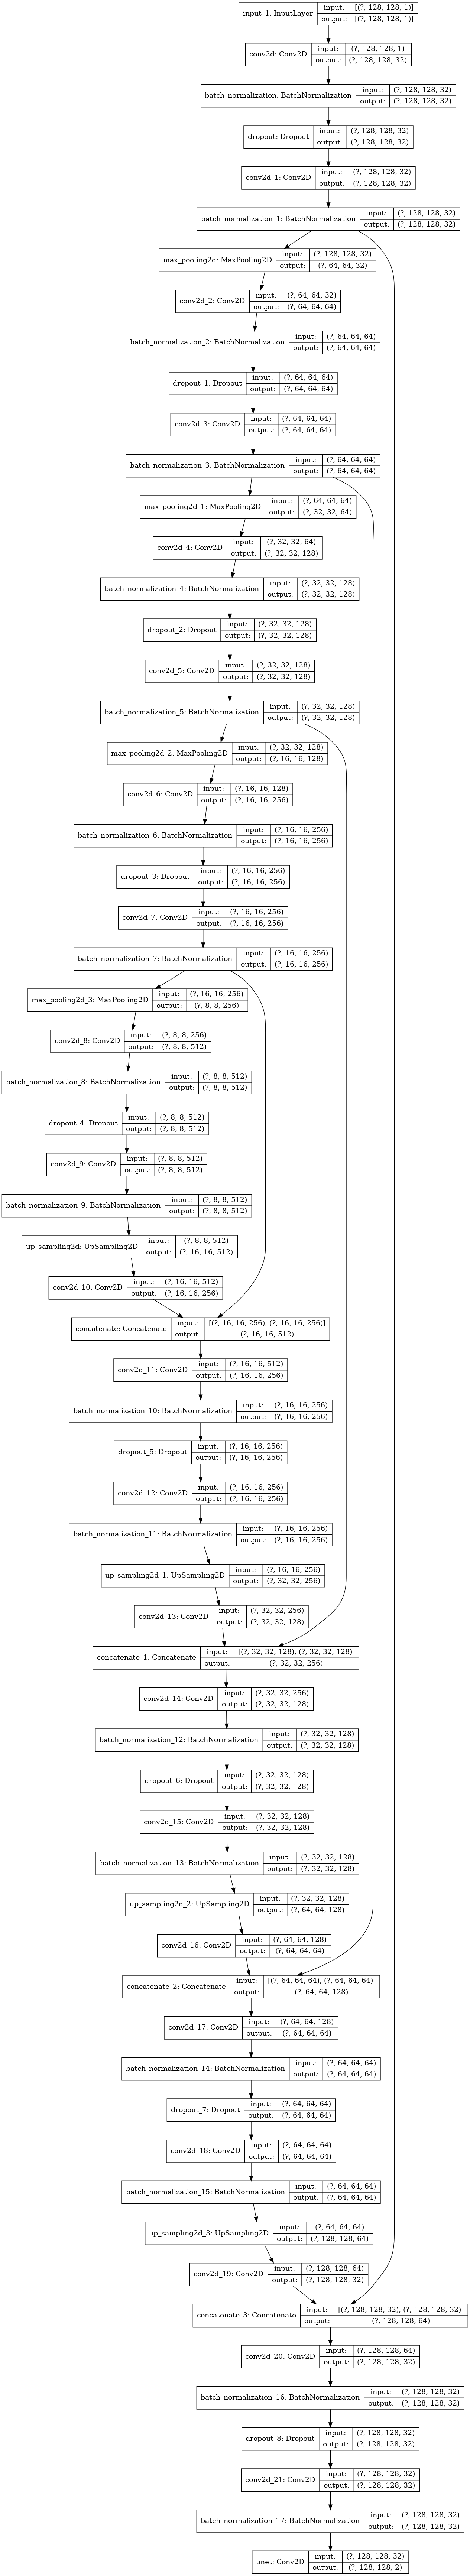

In [5]:
# write the model summary to a txt file
# Open the file
with open(os.path.join(EXP_PATH, 'model_summary.txt') ,'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
    
# Visualizes Model as a plot
tf.keras.utils.plot_model(
    model, show_shapes=True,
    to_file=os.path.join(EXP_PATH, 'model.png'),
    show_layer_names=True, 
    rankdir='TB', 
    expand_nested=True, dpi=96
)
    
#model.summary(line_length=150)

In [6]:
initial_epoch = 0

results = model.fit(
    x=batch_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks = get_callbacks(config, batch_generator,validation_generator),
    initial_epoch=initial_epoch,
    max_queue_size=12,
    verbose=1)

2021-10-08 13:44:06,490 INFO feed 4 Tensorboard is ready


Epoch 1/500
177/178 [============================>.] - ETA: 0s - loss: 0.3642 - dice_coef_labels: 0.0010 - dice_coef_lower: 0.0011 - dice_coef_upper: 0.0010
Epoch 00001: loss improved from inf to 0.36405, saving model to exp/TeaMRT_Exp_5_Sigmoid_BCE/2021-10-08_13_43/model/model.h5
178/178 [==============================] - 7s 40ms/step - loss: 0.3641 - dice_coef_labels: 0.0010 - dice_coef_lower: 0.0011 - dice_coef_upper: 0.0010 - val_loss: 0.3991 - val_dice_coef_labels: 0.0010 - val_dice_coef_lower: 0.0011 - val_dice_coef_upper: 0.0010 - lr: 1.0000e-04
Epoch 2/500
177/178 [============================>.] - ETA: 0s - loss: 0.3176 - dice_coef_labels: 0.0011 - dice_coef_lower: 0.0011 - dice_coef_upper: 0.0011
Epoch 00002: loss improved from 0.36405 to 0.31747, saving model to exp/TeaMRT_Exp_5_Sigmoid_BCE/2021-10-08_13_43/model/model.h5
178/178 [==============================] - 12s 67ms/step - loss: 0.3175 - dice_coef_labels: 0.0011 - dice_coef_lower: 0.0011 - dice_coef_upper: 0.0011 - va

# run all cells for training, this cell will terminate the current jupyter process 
## --> free all ressours after the training has finished

It is recommended this is done or the Kernel is restarted before starting training on a new fold.

In [ ]:
# run all cells for training, this cell will terminate the current jupyter process 
# --> free all ressours after the training has finished
os.system('kill %d' % os.getpid())